# Grab Gaia data and format it for Firefly

Create a conda env

```
conda create --name Gaia python=3.10 astropy astroquery jupyter scipy numpy matplotlib pandas h5py eventlet flask flask-socketio requests
```


In [60]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from astroquery.gaia import Gaia
from astropy.table import Table, Column
import astropy.units as u
from astropy.coordinates import SkyCoord, ICRS
from astropy.io import ascii

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
GaiaCatalog = "gaiaedr3.gaia_source" 

In [ ]:
# def queryMagnitudeBin(gmin,gmax,N):
    columns = 'ra, dec, parallax, pmra, pmdec, dr2_radial_velocity, phot_g_mean_mag, bp_rp'

    cmd = f"SELECT TOP {int(N)} {columns} \
    FROM {GaiaCatalog} \
    WHERE phot_g_mean_mag>{gmin} \
    and phot_g_mean_mag<={gmax} \
    AND parallax IS NOT NULL \
    AND dr2_radial_velocity IS NOT NULL"
    print(cmd)

    #synchronous commands are OK for jobs with < 2000 output rows
    job = Gaia.launch_job(cmd, dump_to_file=False) 

    #asynchronous commands for larger files
    job = Gaia.launch_job_async(cmd, dump_to_file=False)
    print(job)
    GaiaData = job.get_results()
    return GaiaData

magnitudeEdges = [0,10,11,12,13,14]
dfs = []
for i,gmax in enumerate(magnitudeEdges[1:]):
    gmin = magnitudeEdges[i]
    dfs+=[queryMagnitudeBin(gmin,gmax,1e7)]

## Convert these ra, dec, parallax coordinates to 3D cartesian

A better way may be to use the Bailer-Jones distances...

In [374]:
def saveToDisk(GaiaData,gmin,gmax):
    mask = ( (GaiaData['parallax'] > 0) &
         ~np.isnan((GaiaData['parallax'])) &
         ~np.isnan((GaiaData['phot_g_mean_mag'])) &
         ~np.isnan((GaiaData['bp_rp'])) &
         ~np.isnan((GaiaData['dr2_radial_velocity'])) 
       )

    useGaiaData = GaiaData[mask]
    print(np.sum(mask),'many particles')
    
    coordsRV = ICRS(ra = useGaiaData['ra'], 
              dec = useGaiaData['dec'], 
              distance = (useGaiaData['parallax']).to(u.parsec, equivalencies=u.parallax()),
              pm_ra_cosdec = useGaiaData['pmra'],
              pm_dec = useGaiaData['pmdec'], 
              radial_velocity = useGaiaData['dr2_radial_velocity'])

    outdfRV = pd.DataFrame()
    outdfRV['x'] = coordsRV.cartesian.x.value
    outdfRV['y'] = coordsRV.cartesian.y.value
    outdfRV['z'] = coordsRV.cartesian.z.value
    outdfRV['vx'] = coordsRV.velocity.d_x.value
    outdfRV['vy'] = coordsRV.velocity.d_y.value
    outdfRV['vz'] = coordsRV.velocity.d_z.value
    outdfRV['bp_rp'] = np.array(useGaiaData['bp_rp'].data)
    outdfRV['phot_g_mean_mag'] = np.array(useGaiaData['phot_g_mean_mag'].data)

    # export this to a csv file for now
    outdfRV.to_csv('GaiaedR3RV%d-%d.csv'%(gmin,gmax))

In [375]:
for i,gmax in enumerate(magnitudeEdges[1:]):
    gmin = magnitudeEdges[i]
    saveToDisk(dfs[i],gmin,gmax)

335938 many particles
575690 many particles
1432914 many particles
2944254 many particles
1617465 many particles


In [239]:
from firefly.data_reader import ArrayReader

(array([ 2.,  7., 15., 13., 18., 18., 14.,  6.,  4.,  3.]),
 array([1.55622705, 2.05395579, 2.55168452, 3.04941326, 3.547142  ,
        4.04487074, 4.54259948, 5.04032822, 5.53805696, 6.0357857 ,
        6.53351444]),
 <BarContainer object of 10 artists>)

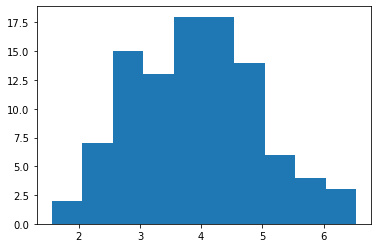

In [265]:
plt.hist(temps)

In [277]:
from scipy.interpolate import interp1d

In [240]:
df = pd.read_csv('tmpGaia.csv')
coordinates = np.zeros((df.shape[0],3))
velocities = np.zeros((df.shape[0],3))

for i,axis in enumerate(['x','y','z']):
    coordinates[:,i] = df[axis]
    velocities[:,i] = df[f'v{axis}']
coordinates

array([[  44.74708905, -198.27386341,   20.21138422],
       [  94.1784582 , -341.35400452,   35.64754174],
       [  47.42737877, -201.80665677,   21.73701154],
       ...,
       [-480.48988524, -141.51911534, -861.66774804],
       [-136.36987599,  -39.3087655 , -245.32609517],
       [-498.94824416, -146.43772507, -892.23702308]])

In [357]:
fields = {key:df[key].to_numpy() for key in ['bp_rp','phot_g_mean_mag']}
fields['minus_mag'] = -fields['phot_g_mean_mag']
fields['log10Temperature'] = temps
for key,value in fields.items():
    print(key,np.min(value),np.max(value))


bp_rp -0.1259861 7.2997017
phot_g_mean_mag 2.4740036 12.0
minus_mag -12.0 -2.4740036
log10Temperature 3.3372207063318906 4.999980577312683


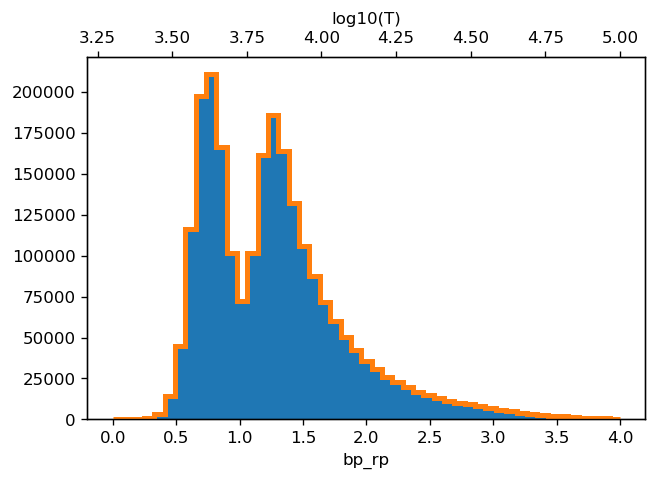

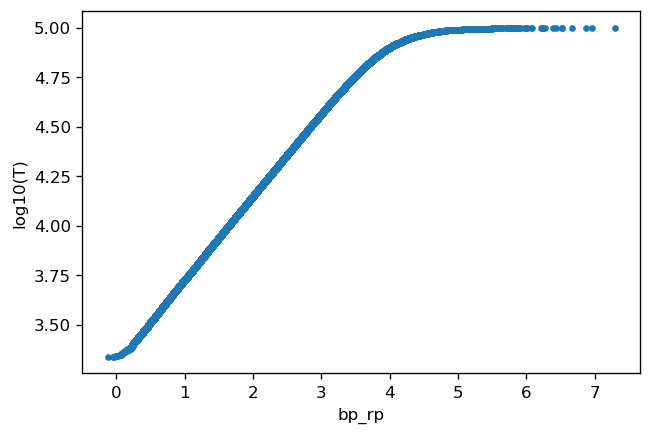

In [376]:
import matplotlib.pyplot as plt
%matplotlib inline

def remap_nonparametrically(values,old_interval,new_interval):
    h,_ = np.histogram(values,bins=np.linspace(*old_interval))
    new_edges = np.linspace(*new_interval)
    probs = np.cumsum(h)/np.sum(h)
    probs[0] = 0
    inverter = interp1d(probs,temp_edges[1:])
    new_values = inverter(np.random.uniform(0,1,df.shape[0]))
    
    sort_indices = np.argsort(values)
    new_values = np.sort(new_values)[np.argsort(sort_indices)]
    return new_values
    
    

old_interval = (0,4)
new_interval = (np.log10(2e3),5)

h,edges,p = plt.hist(fields['bp_rp'],bins=np.linspace(*old_interval))
ax1 = plt.gca()
ax2 = ax1.twiny()
temps = remap_nonparametrically(fields['bp_rp'],old_interval,new_interval)
ax2.hist(temps,bins=np.linspace(*new_interval),histtype='step',color='C1',lw=3)

ax1.set_xlabel('bp_rp')
ax2.set_xlabel('log10(T)')
plt.gcf().set_facecolor('white')
plt.gcf().set_dpi(120)

plt.figure()
plt.plot(bp_rps,temps,'.')
plt.gca().set_ylabel('log10(T)')
plt.gca().set_xlabel('bp_rp')
plt.gcf().set_dpi(120)
plt.gcf().set_facecolor('white')

In [358]:
reader = ArrayReader(
    ## don't have to pass as a list with 1 element 
    ##  if only 1 particle group
    coordinates,
    velocities,
    'eDR3RV',
    fields,
    JSONdir='GaiaeDR3', ## if not an absolute path assumes from ~
    clean_JSONdir=True, ## delete old files in the directory
    write_startup=True, ## overwrite the startup file (and turn off PG append)
    write_to_disk=False, ## whether to write to disk at the end of __init__
    field_filter_flags=[True,True,False,True], ## flags corresponding to fields
    field_colormap_flags=[True,True,False,True],
    field_radius_flags=[False,False,True,False],
)

JSONdir: /Users/agurvich/GaiaeDR3 -- is not a sub-directory of firefly/static/data. 
This may produce confusing or inoperable results. As such, we will create a symlink for you when you writeToDisk.
filter/colormap/radius flags correspond to: ['bp_rp', 'phot_g_mean_mag', 'minus_mag', 'log10Temperature']
Outputting: eDR3RV - 2344542/2344542 particles - 5 tracked fields


In [360]:
reader.settings['sizeMult']['eDR3RV'] = 0.2
#reader.settings['radiusVariable']['eDR3-RV'] = 1

## pick the last colormap, blackbody
index = (256/8-1)
reader.settings['colormap']['eDR3RV'] = (index + 0.5) * (8/256)
reader.settings['colormapVariable']['eDR3RV'] = 2
reader.settings['depthTest'] = False
reader.settings['blendingMode'] = 'additive'
reader.settings['showColormap']['eDR3RV'] = True
reader.settings['GUIExcludeList'] = [
    'eDR3RV/dropdown/general/blendingModeSelectors',
    'eDR3RV/dropdown/colormap/colormapCheckBox',
    'eDR3RV/colorPicker',
    'eDR3RV/dropdown/general/radiusVariableSelector']

reader.writeToDisk()

''

In [352]:
reader.copyFireflySourceToTarget('Gaia_test',init_gh_pages=False,overwrite=True,dump_data=True)

['/Users/agurvich/Gaia_test']

In [ ]:
reader.createOctrees([True],npart_min_node=1e4,npart_max_node=1e5)

In [ ]:
## symlink = False -> data will be copied to static/data
reader.writeToDisk(symlink=False)